## Семинар 5: "Улучшение сходимости нейросетей"

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Инициализация весов
* Dropout
* Batch Normalization


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.66MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 210kB/s]
100%|██████████| 1.65M/1.65M [00:03<00:00, 444kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.66MB/s]


In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

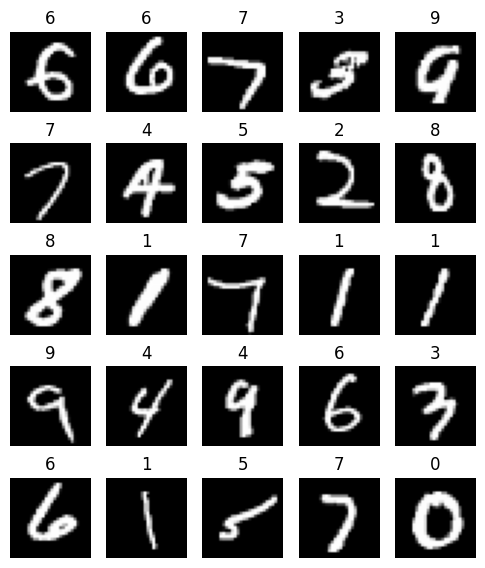

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

Создадим два линейных слоя и инициализируем их случайным образом. Для этого используем uniform распределение с нулевым средним и большим отклонением.

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=mean, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [7]:
layer_1 = nn.Linear(28 * 28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

Соберем все вместе, используя ReLU в качестве функции активации:

In [8]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

Посчитаем дисперсию активаций и диспресию градиентов:

In [9]:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 1.044552206993103
forward 17.139019012451172
backward 0.04642795771360397
backward 0.19762784242630005


/opt/anaconda3/envs/dl-course/lib/python3.10/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Теперь попробуем использовать инициализацию He:<br>
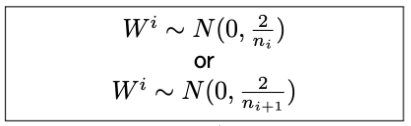

In [10]:
layer_1 = nn.Linear(28 * 28, 500)
layer_2 = nn.Linear(500, 10)


layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1, 0, 2 / 500)
init_layer(layer_2, 0, 2 / 10)

In [11]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 1.044552206993103
forward 0.0684090107679367
backward 0.04642795771360397
backward 0.043935470283031464


## Часть 2: Dropout

Реализуем Dropout:

* Train: с вероятностью p занулим выход нейрона (например, p = 0.5)
* Test: домножаем веса на вероятность сохранения

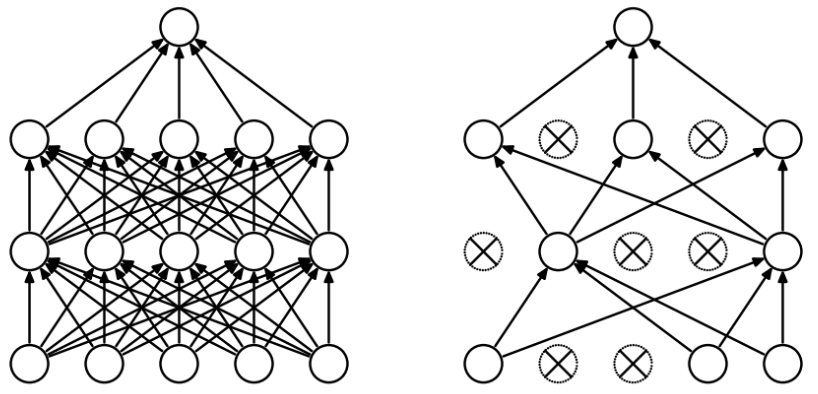


In [12]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        mask = torch.empty(x.shape).uniform_(0, 1).type(torch.FloatTensor)
        if self.training:
            mask = torch.where(mask > self.p, 1, 0)
        else:
            mask = torch.where(mask > self.p, 1, 1 - self.p)

        return x * mask

Основа для сети, которую будем обучать:

In [13]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

In [14]:
layers = [
    nn.Linear(196, 150),
    nn.ReLU(),
    nn.Linear(150, 50),
    nn.ReLU(),
    nn.Linear(50, 10)
]

In [15]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

Обучим получившуюся сеть:

In [16]:
for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.304783
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.468281
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.403388
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.647557
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.204978
Test Epoch: 0	Loss: 0.232974
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.174724
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.277036
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.137835
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.119413
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.213835
Test Epoch: 1	Loss: 0.151960
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.059650
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.081047
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.163830
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.105288
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.093208
Test Epoch: 2	Loss: 0.098111
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.071570
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.143158
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.093073
Train Epoch: 3 [38400/60000 (64%)

In [17]:
layers = [
    nn.Linear(196, 150),
    nn.ReLU(),
    Dropout(),
    nn.Linear(150, 50),
    nn.ReLU(),
    Dropout(),
    nn.Linear(50, 10)
]

In [18]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

In [20]:
for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))


Train Epoch: 0 [0/60000 (0%)]	Loss: 0.236093
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.148698
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.212325
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.201694
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.109270
Test Epoch: 0	Loss: 0.146844
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.225234
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.056100
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.153644
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.146050
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.158881
Test Epoch: 1	Loss: 0.130707
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.105092
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.141736
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.139062
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.212943
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.143988
Test Epoch: 2	Loss: 0.120327
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.134340
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.118764
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.257106
Train Epoch: 3 [38400/60000 (64%)